In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/clear_cloudy_merged/train_B_over_ganaug_025"
plot_title = "train_B_over_ganaug_025"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.872498,0.878,0.683223,0.878,0.660007,0.960046,0.883330,0.931824,0.730666,0.556505
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.894195,0.896,0.748051,0.896,0.734248,0.969345,0.913420,0.946443,0.794003,0.634672
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.897826,0.899,0.757609,0.899,0.748309,0.971935,0.924016,0.950468,0.813818,0.648780
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.903633,0.905,0.771512,0.905,0.759148,0.974188,0.931135,0.954098,0.825298,0.667881
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.903974,0.905,0.769533,0.905,0.760437,0.975311,0.933870,0.956229,0.831385,0.670075


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.868182,0.8715,0.675928,0.8715,0.659840,0.958807,0.880163,0.930299,0.720339,0.542738
1,2,test,0.885429,0.8865,0.723787,0.8865,0.716447,0.967465,0.907076,0.944236,0.780166,0.606658
2,3,test,0.898401,0.8980,0.758529,0.8980,0.760638,0.970787,0.918216,0.949777,0.806904,0.654471
3,4,test,0.901624,0.9015,0.766792,0.9015,0.768618,0.972973,0.924186,0.953916,0.822902,0.665843
4,5,test,0.906132,0.9060,0.775720,0.9060,0.777566,0.974210,0.926267,0.955996,0.830225,0.681110


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/337:,Train,Loss,=,1.639,Valid,Loss,=,1.610,ETA,=,5.66h
1,Epoch,"1/40,",Batch,20/337:,Train,Loss,=,1.548,Valid,Loss,=,1.587,ETA,=,5.07h
2,Epoch,"1/40,",Batch,30/337:,Train,Loss,=,1.511,Valid,Loss,=,1.490,ETA,=,4.75h
3,Epoch,"1/40,",Batch,40/337:,Train,Loss,=,1.470,Valid,Loss,=,1.469,ETA,=,4.11h
4,Epoch,"1/40,",Batch,50/337:,Train,Loss,=,1.453,Valid,Loss,=,1.409,ETA,=,4.30h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.639,1.610
20,1,20,1.548,1.587
30,1,30,1.511,1.490
40,1,40,1.470,1.469
50,1,50,1.453,1.409


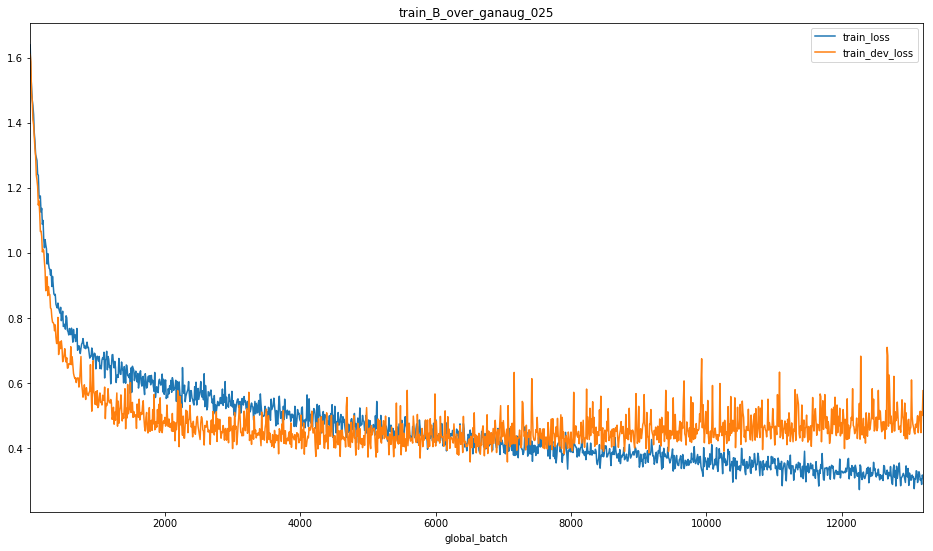

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,1.137,1.066
2,0.801,0.688
3,0.708,0.579
4,0.667,0.539
5,0.628,0.511


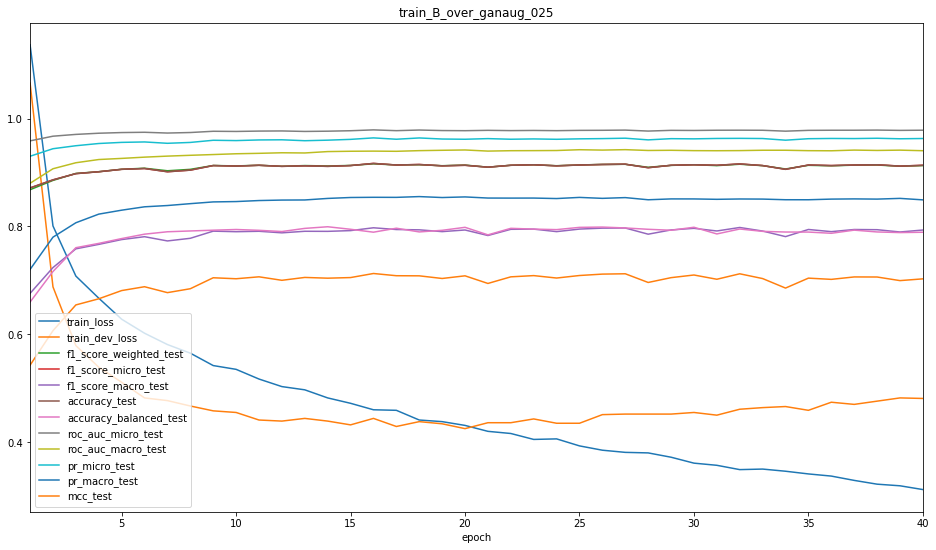

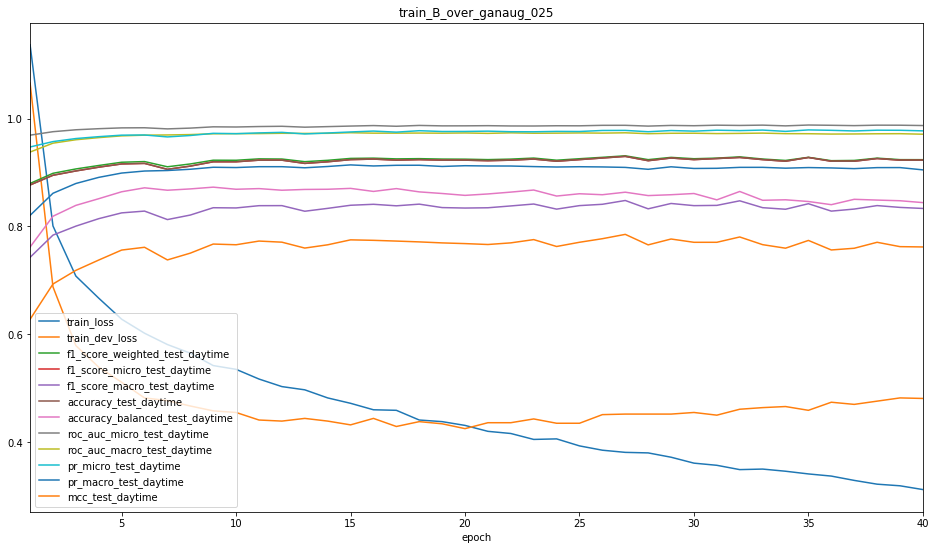

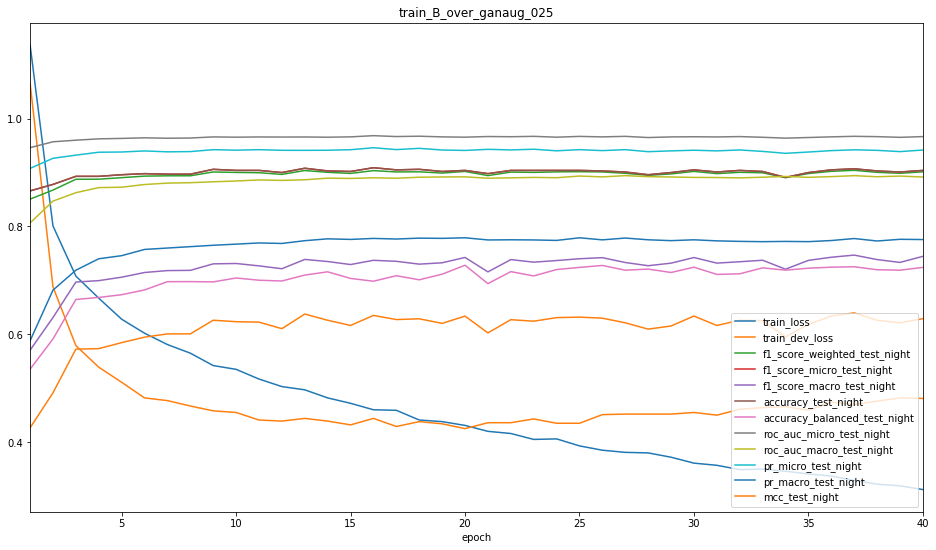

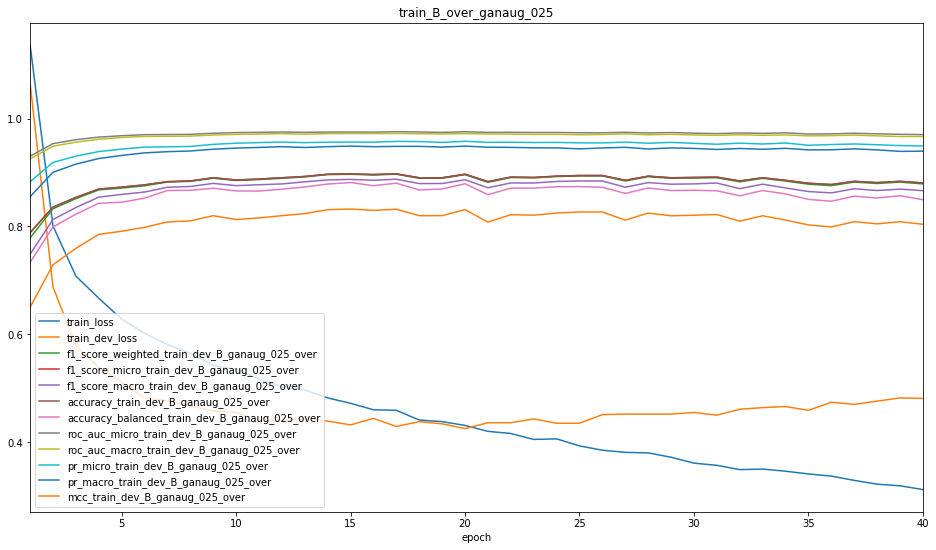

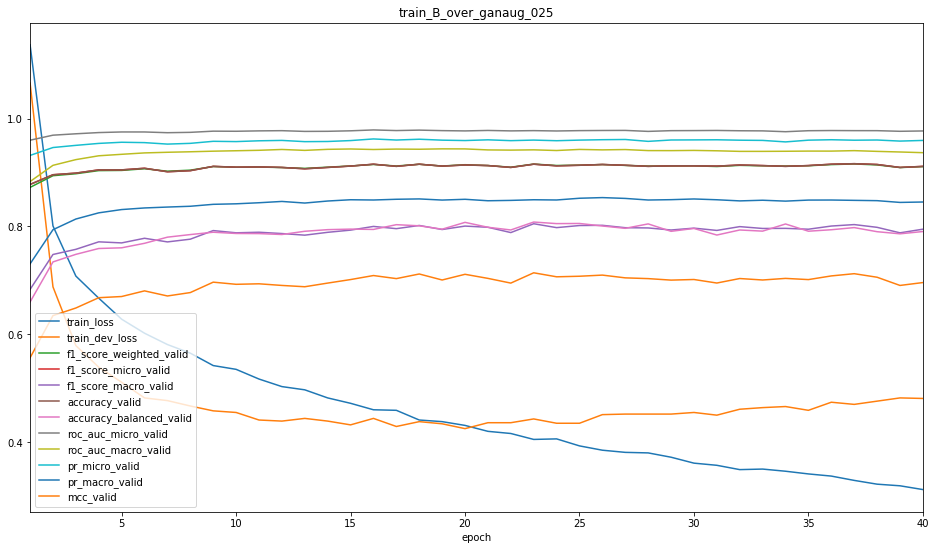

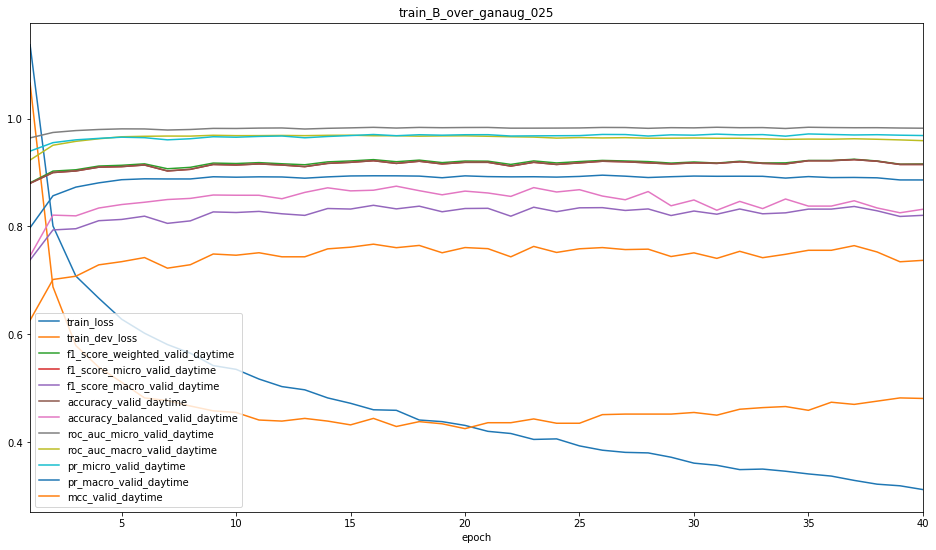

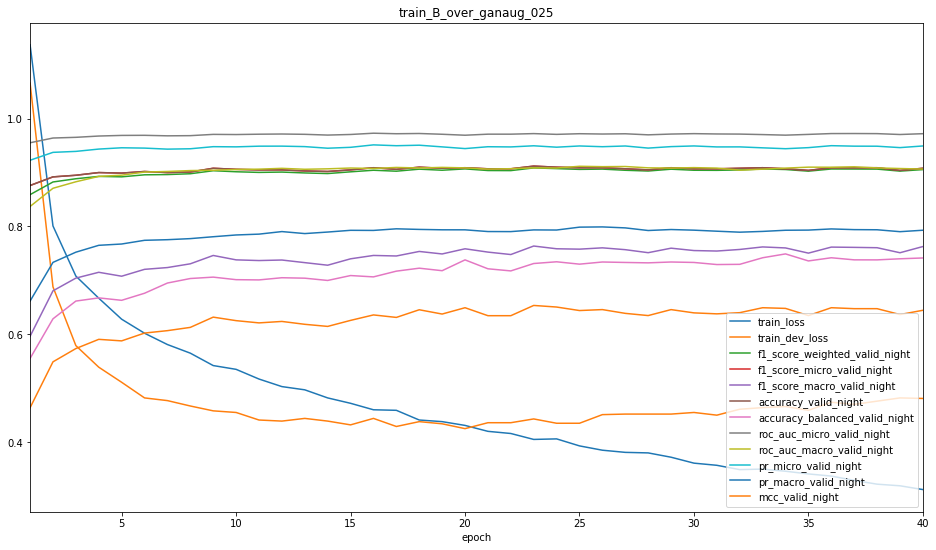

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)